## import

In [2]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from scipy.ndimage import gaussian_filter1d
from wfOpto import *

In [2]:
import pytoolsAL as ptAL

pytoolsAL: Modules missing.  Not loading image.  Message: cannot import name 'geometry' from 'skimage._shared' (c:\Users\nadia\anaconda3\envs\steinmetzlab\Lib\site-packages\skimage\_shared\__init__.py)
It seems that scikit-image has not been built correctly.

Your install of scikit-image appears to be broken.
Try re-installing the package following the instructions at:
https://scikit-image.org/docs/stable/user_guide/install.html
pytoolsAL: Modules missing.  Not loading neuropixels.  Message: No module named 'slidingRP'
pytoolsAL: Modules missing.  Not loading plotting.  Message: No module named 'pandas'


In [3]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [8]:
#personal
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

In [4]:
dataOp425=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [12]:
#loading 6/20 data, its just weird cause files are off
serverPath = Path(r'Y:\Subjects\AB_0032\2024-06-20\3')
svdTemp620 = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat620 = np.load(serverPath / 'blue/svdSpatialComponents.npy')
timeFile620 = serverPath / 'cameraFrameTimes.npy'
frameTimes620 = np.squeeze(np.load(timeFile620))[::2] # every other frame - we want blue only
svdTemp620 = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat620 = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull620 = svdSpat620[:,:,:500]

meanImage620 = np.load(serverPath / 'blue/meanImage.npy')
laserOn620 = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff620 = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
laserPowers620 = np.squeeze(np.load(serverPath /'laserPowers.npy'))
galvoX620 = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY620 = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
px620, py620, ncomps620 = svdSpatFull620.shape

svdSpat620 = svdSpatFull620.reshape(px620*py620, ncomps620)
tToWf620 = scipy.interpolate.interp1d(frameTimes620, svdTemp620[:76232], axis=0, fill_value='extrapolate')
spatial620 = svdSpatFull620.reshape(560*560,-1)
listExps=None
if listExps == None:
    listExps = np.array([np.arange(len(laserPowers620))])
listExps = listExps
pulseLengths = []
for count,time in enumerate(laserOff620):
    length = laserOff620[count]-laserOn620[count]
    length = round(length,2)
    pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)

In [13]:
#titled some of them wrong so have to redo
frameTimes620 = np.squeeze(np.load(timeFile620))[::2] # every other frame - we want blue only
svdTemp620 = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat620 = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull620 = svdSpat620[:,:,:500]

In [14]:
#titled these wrong as well
pulseLengths620 = []
for count,time in enumerate(laserOff620):
    length = laserOff620[count]-laserOn620[count]
    length = round(length,2)
    pulseLengths620.append(length)
pulseLengths620 = np.array(pulseLengths620)

In [39]:
print(np.unique(galvoY620))
print(np.unique(galvoX620))
print(np.unique(laserPowers620))
print(np.unique(pulseLengths620))

[3.]
[3.]
[0.7 1.5]
[0.01 0.02 0.1  0.2  0.5  1.   2.  ]


## Power:Inactivation figs

In [121]:
def powerDep3Pow(ax,data,ylim):
    colors=['deepskyblue','dodgerblue','mediumblue']
    powers = np.array([0.2,1.7,3])
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(data.laserPowers == power).ravel()
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)
        for c,iP in enumerate(pxPowers):
            iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
        plt.fill_between(timestamps, \
                 np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
                 np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
        plt.legend(['0.07 mW', '0.63 mW', '1.1 mW'], loc='upper right',bbox_to_anchor=(1.2,1))
        plt.xlabel('Time (ms)')
        plt.ylabel('Brain Activity ($\Delta F$/F)')
        plt.title('Inactivation 3 Powers')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
        plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
        plt.ylim(ylim)
    

<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_2008\173386258.py:33: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Brain Activity ($\Delta F$/F)')


In [122]:
def powerDepAllPow(ax,data,ylim):
    powers = np.unique(laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(data.laserPowers == power).ravel()
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

        for iP in pxPowers:
            iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0),color='k')
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
        plt.xlabel('time (ms)')
        plt.title('Inactivation All Powers')
        plt.ylim(ylim)

In [123]:
def powerQuant(ax,data):
    powers = np.unique(data.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(data.laserPowers == power).ravel()
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k',lw=2)
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.scatter(powers,timeMean)
    plt.xlabel("Laser powers (mW)")
    plt.title("Inactivation at Peak (90 ms)")

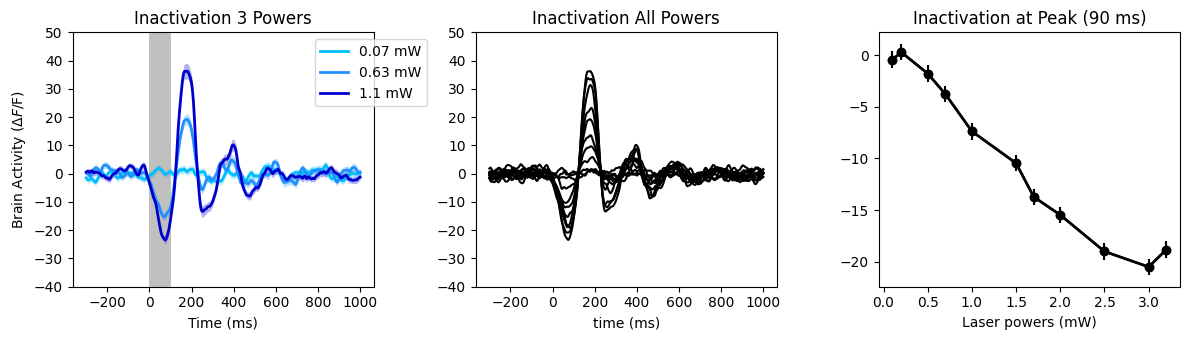

In [127]:
f = plt.figure(figsize=(12, 3.5))
gs = mpl.gridspec.GridSpec(1, 3)

ylim=[-40,50]
ax = plt.subplot(gs[0])
powerDep3Pow(ax,data,ylim)

ax = plt.subplot(gs[1])
powerDepAllPow(ax,data,ylim)

ax = plt.subplot(gs[2])
powerQuant(ax,data)

f.tight_layout()

In [128]:
mouse='AB_0032'
date="4.25"

In [131]:
f.savefig(f'C:/GitHub/steinmetzlab/wf + opto/figs/opto/{mouse}powDep_{date}.png')

## Stim Length figs

In [3]:
data=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-05-23\1'))

In [4]:
print(np.unique(data.laserPowers))
print(np.unique(data.galvoX))
print(np.unique(data.galvoY))

[0.2 0.5 0.7]
[2.  2.3 2.5 2.8]
[6.  6.2]


In [5]:
serverPath = Path(r'Y:\Subjects\AB_0032\2024-05-21\1')
timeFile = serverPath / 'cameraFrameTimes.npy'
frameTimes = np.squeeze(np.load(timeFile))[::2] # every other frame - we want blue only
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull = svdSpat[:,:,:500]

meanImage = np.load(serverPath / 'blue/meanImage.npy')
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
laserPowers = np.squeeze(np.load(serverPath /'laserPowers.npy'))
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
px, py, ncomps = svdSpatFull.shape

svdSpat = svdSpatFull.reshape(px*py, ncomps)

In [29]:
np.unique(galvoY)

array([6.])

In [6]:
tToWf = scipy.interpolate.interp1d(frameTimes[:(svdTemp.shape[0])], svdTemp, axis=0, fill_value='extrapolate')
spatial = svdSpatFull.reshape(560*560,-1)

In [7]:
pulseLengths = []
for count,time in enumerate(laserOff):
    length = laserOff[count]-laserOn[count]
    length = round(length,2)
    pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)

In [148]:
np.unique(pulseLengths)

array([0.1])

In [142]:
svdTemp.shape

(70943, 500)

In [143]:
frameTimes.shape

(118378,)

#### organized panels

In [4]:
def stimDepPow(ax,ylim,data,pow):
    lens = np.unique(data.pulseLengths)
    power=pow
    pws=np.argwhere(data.laserPowers==power).ravel()
    pixel = (198, 246)
    pxLen = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))
    for iP, len in enumerate(lens):
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs=np.intersect1d(lenTrs,pws)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisLen = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisLen.append(mov)
        thisLen = np.array(thisLen)
        pxLen.append(thisLen)
    pxLen=np.array(pxLen)

    for iP in pxLen:
        iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP,axis=0),color='k')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$/F')
    plt.title('temporal resolution over laser durations')
    plt.ylim(ylim)

<>:34: SyntaxWarning: invalid escape sequence '\D'
<>:34: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_5236\3161012557.py:34: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$/F')


In [5]:
def stimDepPowMod(ax,ylim,data,pow,lenList):
    colors=['deepskyblue','dodgerblue','mediumblue','indigo','violet','darkviolet','deeppink']
    power=pow
    pws=np.argwhere(data.laserPowers==power).ravel()
    lens = lenList
    pixel = (198, 246)
    pxLens = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (data.py, data.px))

    for iP, len in enumerate(lens):
        lenTrs = np.argwhere(data.pulseLengths == len).ravel()
        theseTrs=np.intersect1d(lenTrs,pws)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisLen = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisLen.append(mov)
        thisLen = np.array(thisLen)
        pxLens.append(thisLen)
    for c,iP in enumerate(pxLens):
        iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
        # plt.fill_between(timestamps, \
        #         np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
        #         np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
    plt.legend(lens, loc='upper right',bbox_to_anchor=(1.2,1))
    plt.xlabel('Time (ms)')
    plt.title(f'{lenList.shape} Pulse Lengths')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.ylim(ylim)

NameError: name 'data' is not defined

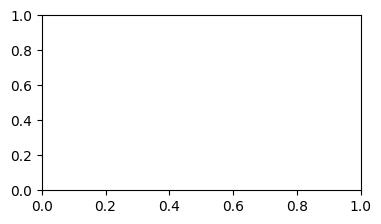

In [6]:
f = plt.figure(figsize=(14, 5))
gs = mpl.gridspec.GridSpec(2,3)
pow=.7
lenList=np.array([0.01,0.1,1,3])
ylim=[-15,20]

ax = plt.subplot(gs[0])
stimDepPow(ax,ylim,data,pow)

ax = plt.subplot(gs[1])
stimDepPowMod(ax,ylim,data,pow,lenList)

f.tight_layout()

<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_2008\2916904775.py:38: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$/F')


(25, 650)
(26, 650)
(25, 650)
(26, 650)
(25, 650)
(25, 650)


(-50.0, 50.0)

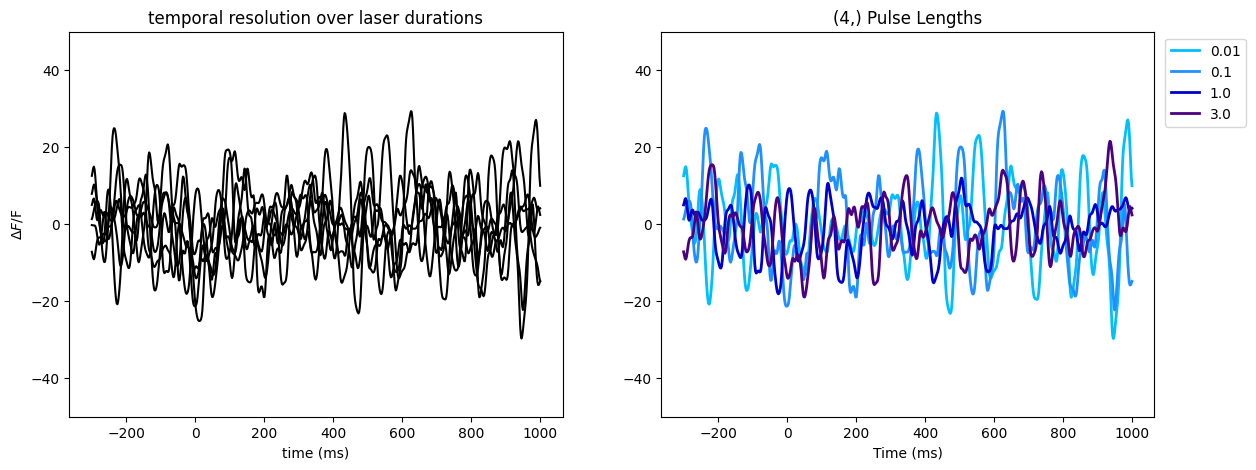

In [170]:
f = plt.figure(figsize=(14, 5))
gs = mpl.gridspec.GridSpec(1,2)
ylim=[-50,50]
lens = np.unique(pulseLengths)
power=pow
pws=np.argwhere(laserPowers==power).ravel()
pixel = (198, 246)
pxLen = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((246, 198), (py, px))
for iP, len in enumerate(lens):
    lenTrs = np.argwhere(pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisLen = []
    for iT, tr in enumerate(trs):
        wf = tToWf(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = svdSpat[pixel_ix] @ dwf
        thisLen.append(mov)
    thisLen = np.array(thisLen)
    print(thisLen.shape)
    pxLen.append(thisLen)
#pxLen=np.array(pxLen)

ax = plt.subplot(gs[0])
for iP in pxLen:
    iP = gaussian_filter1d(iP, sigma=2)
    plt.plot(timestamps, np.mean(iP,axis=0),color='k')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$/F')
plt.title('temporal resolution over laser durations')
plt.ylim(ylim)

############################################################ 
############# 3 powers ###############
###########################################################
colors=['deepskyblue','dodgerblue','mediumblue','indigo','violet','darkviolet','deeppink']
power=pow
pws=np.argwhere(laserPowers==power).ravel()
lens = lenList
pixel = (198, 246)
pxLens = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((246, 198), (py, px))

for iP, len in enumerate(lens):
    lenTrs = np.argwhere(pulseLengths == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisLen = []
    for iT, tr in enumerate(trs):
        wf = tToWf(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = svdSpat[pixel_ix] @ dwf
        thisLen.append(mov)
    thisLen = np.array(thisLen)
    pxLens.append(thisLen)

ax = plt.subplot(gs[1])
for c,iP in enumerate(pxLens):
    iP = gaussian_filter1d(iP, sigma=2)
    plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
    # plt.fill_between(timestamps, \
    #         np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
    #         np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
plt.legend(lens, loc='upper right',bbox_to_anchor=(1.2,1))
plt.xlabel('Time (ms)')
plt.title(f'{lenList.shape} Pulse Lengths')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
plt.ylim(ylim)

### testing and disorganized stuff

one panel for each length
- goal - see the avg response to each laser length

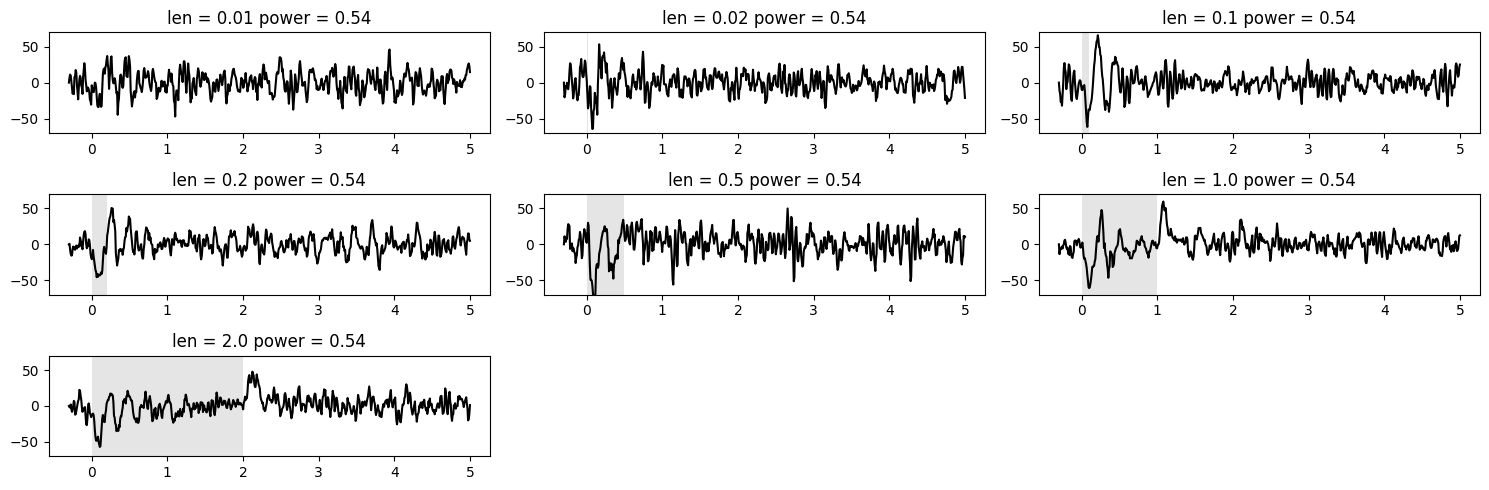

In [60]:
lens = np.unique(pulseLengths620)
power=1.5 
pws=np.argwhere(laserPowers620==power).ravel()
pixel = (150, 450)
pxLen = []
n_samples = 650
start=-.3
stop=5
timestamps = np.linspace(start, stop, n_samples)


pixel_ix = np.ravel_multi_index((450, 150), (py620, px620))
for iP, len in enumerate(lens):
    #find the trials for this length
    lenTrs = np.argwhere(pulseLengths620 == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = laserOn620[theseTrs]
    #make trial times
    trs = [np.linspace(start+on, stop+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisLen = []
    for iT, tr in enumerate(trs):
        wf = tToWf620(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = spatial620[pixel_ix] @ dwf
        thisLen.append(mov)
    thisLen = np.array(thisLen) #the activity for this length
    pxLen.append(thisLen) #appending to an array for all the lengths
pxLen=np.array(pxLen)
f = plt.figure(figsize=(15, 5))
gs = mpl.gridspec.GridSpec(3,3) #3 rows, 3 columns

for iLen,whichLen in enumerate(pxLen):
    ax = plt.subplot(gs[iLen])
    ax.plot(timestamps, np.mean(whichLen,axis=0),color='k') #plotting mean across the trials of that length
    ax.set_title(f'len = {lens[iLen]} power = {power/2.777778:.02f}')
    ax.axvspan(0,lens[iLen],color='gray',alpha=.2,lw=0,label='_nolegend_')
    ax.set_ylim([-70,70])
f.tight_layout()

lets zoom in on first 3 sec for sanity

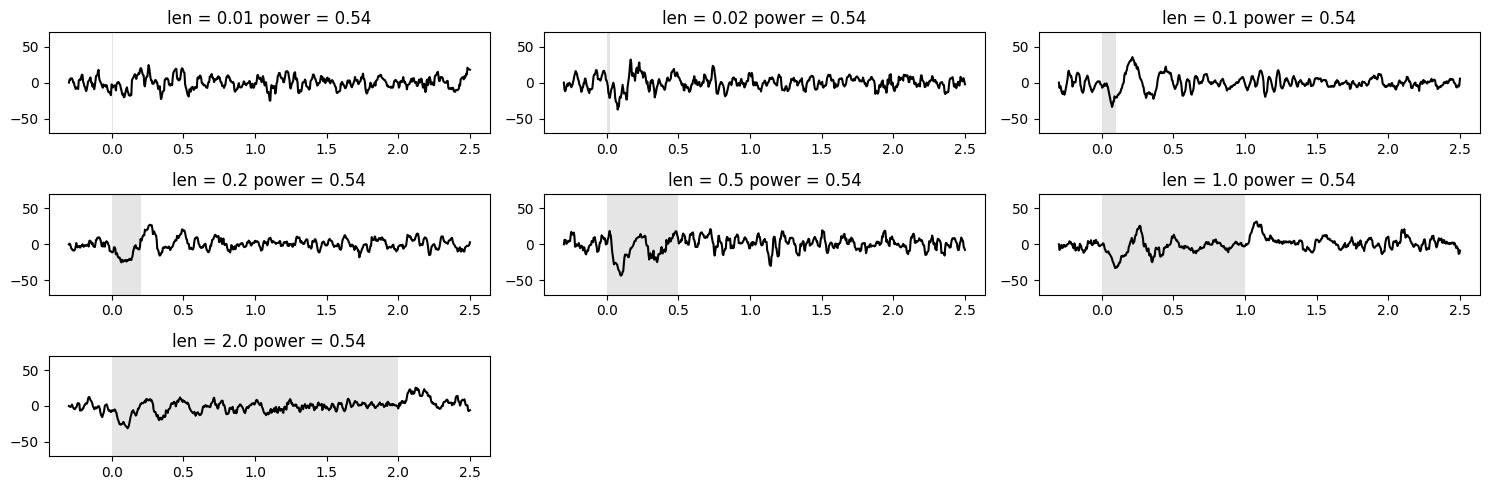

In [57]:
lens = np.unique(pulseLengths620)
power=1.5 
pws=np.argwhere(laserPowers620==power).ravel()
pixel = (150, 450)
pxLen = []
n_samples = 650
start=-.3
stop=2.5
timestamps = np.linspace(start, stop, n_samples)

pixel_ix = np.ravel_multi_index((450, 150), (py620, px620))
for iP, len in enumerate(lens):
    #find the trials for this length
    lenTrs = np.argwhere(pulseLengths620 == len).ravel()
    theseTrs=np.intersect1d(lenTrs,pws)
    onTimes = laserOn620[theseTrs]
    #make trial times
    trs = [np.linspace(start+on, stop+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisLen = []
    for iT, tr in enumerate(trs):
        wf = tToWf620(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = spatial620[pixel_ix] @ dwf
        thisLen.append(mov)
    thisLen = np.array(thisLen) #the activity for this length
    pxLen.append(thisLen) #appending to an array for all the lengths
pxLen=np.array(pxLen)
f = plt.figure(figsize=(15, 5))
gs = mpl.gridspec.GridSpec(3,3) #3 rows, 3 columns

for iLen,whichLen in enumerate(pxLen):
    ax = plt.subplot(gs[iLen])
    ax.plot(timestamps, np.mean(whichLen,axis=0),color='k') #plotting mean across the trials of that length
    ax.set_title(f'len = {lens[iLen]} power = {power/2.777778:.02f}')
    ax.axvspan(0,lens[iLen],color='gray',alpha=.2,lw=0,label='_nolegend_')
    ax.set_ylim([-70,70])
f.tight_layout()

create 30 panels for all trials of each stim length
- goal - to see if theres something wrong with my trials

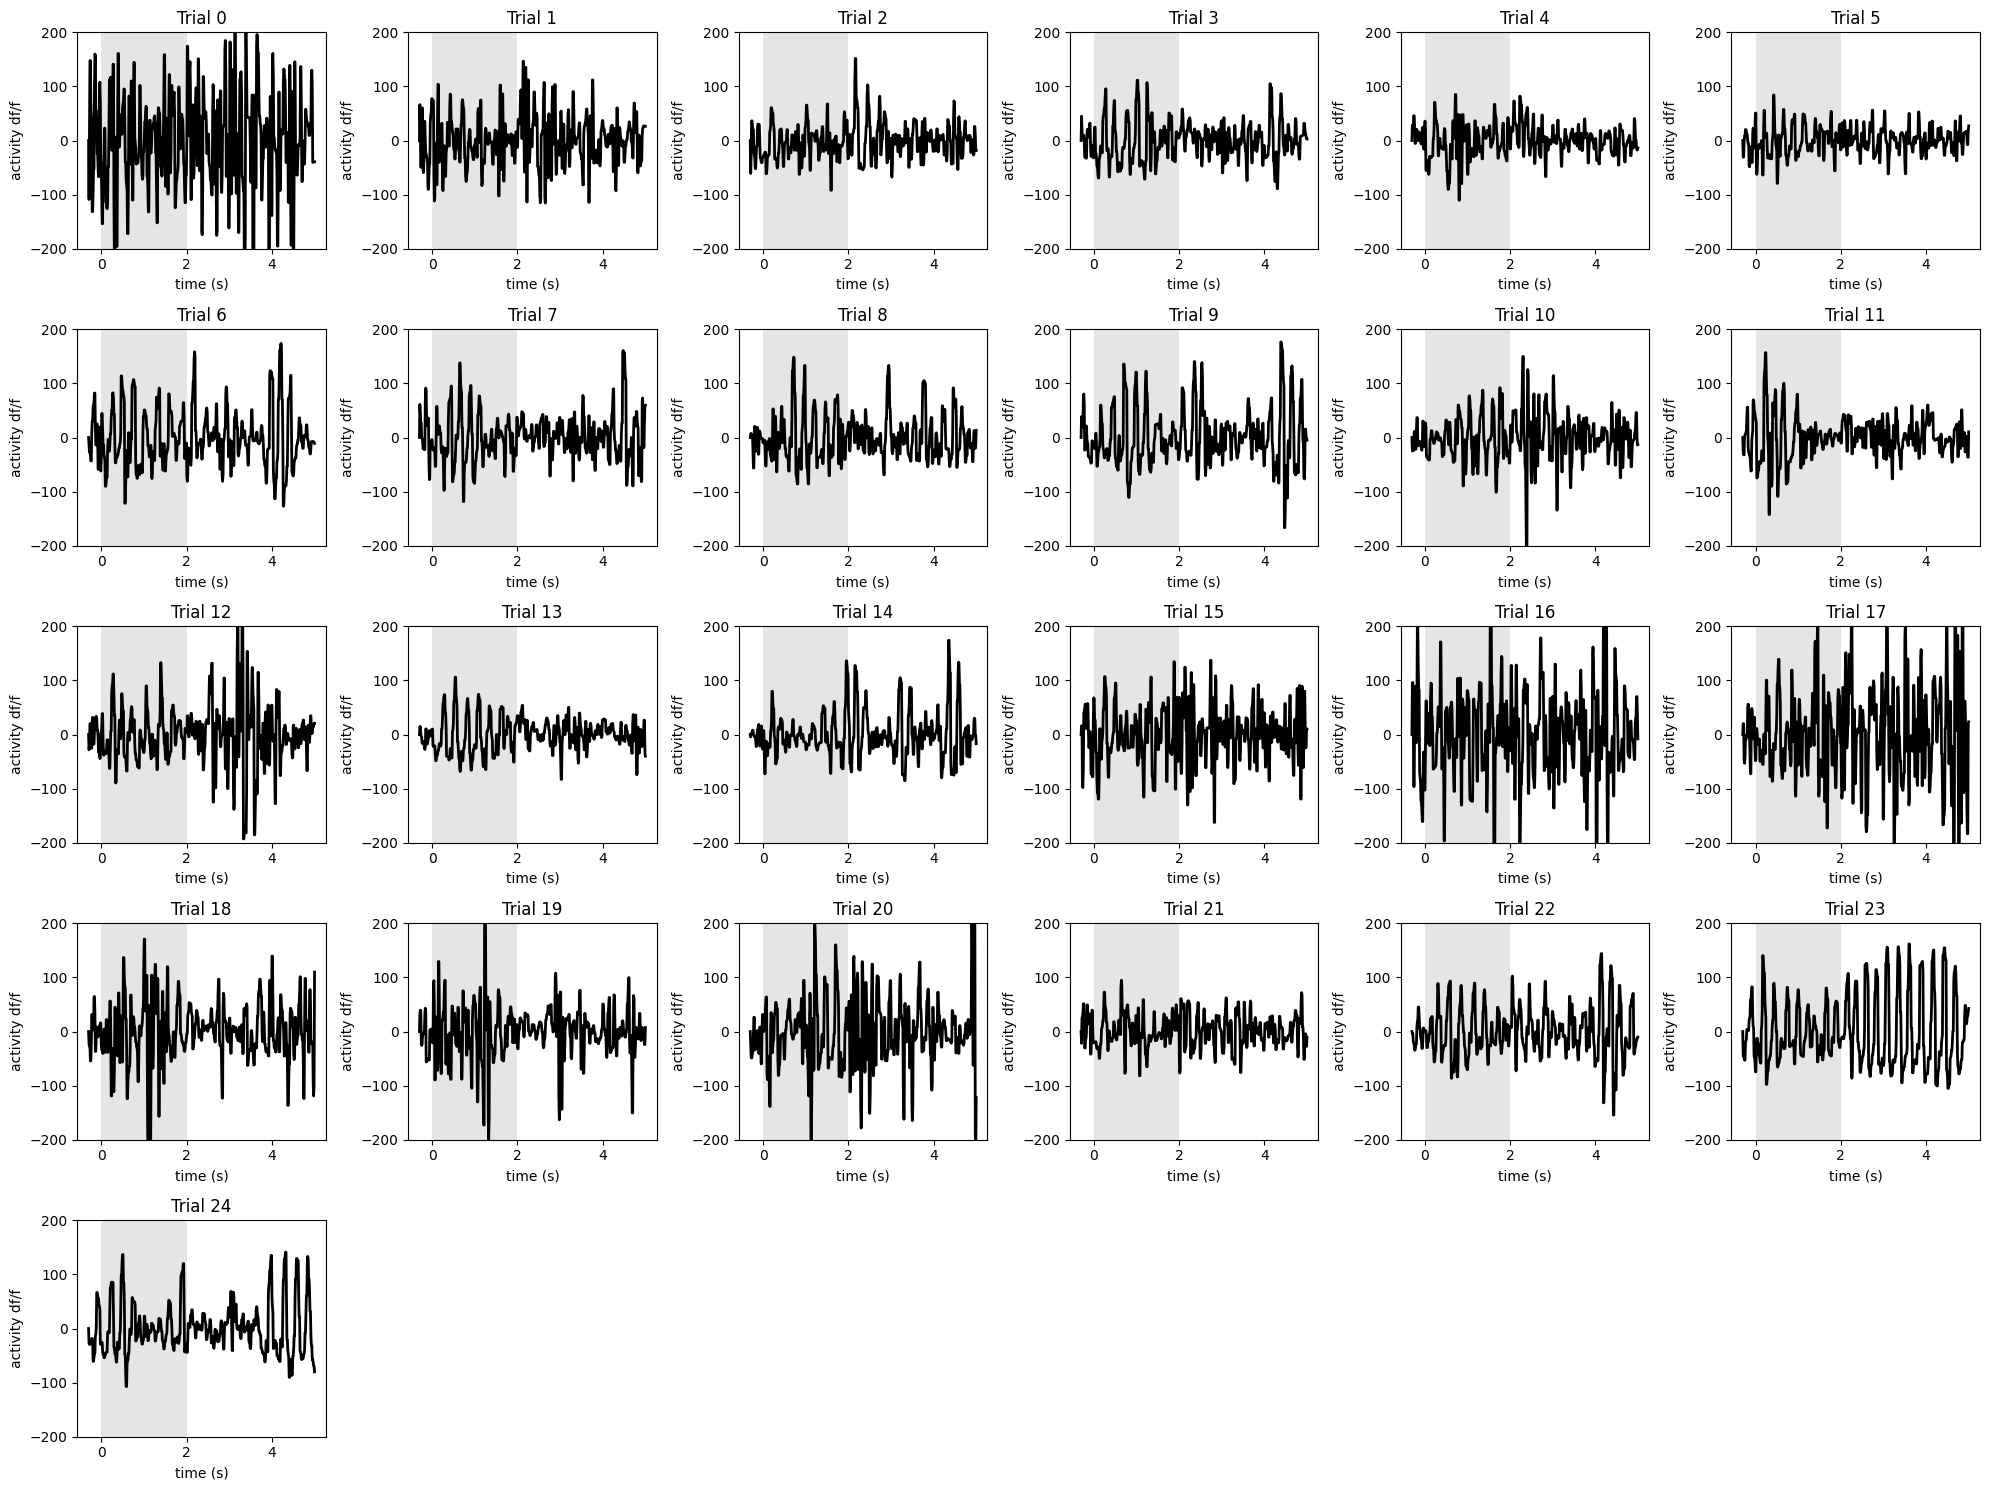

In [81]:
f = plt.figure(figsize=(20,15))
gs = mpl.gridspec.GridSpec(5,6) #all 30 (25) panels

#presets and needs
power=1.5
len=2
pixel_ix = np.ravel_multi_index((450, 198), (py620, px620))
n_samples = 500
start=-.3
stop=5
timestamps = np.linspace(start, stop, n_samples)

#finding trs
pwTrs=np.argwhere(laserPowers620==power).ravel()
lenTrs = np.argwhere(pulseLengths620 == len).ravel()
theseTrs=np.intersect1d(lenTrs,pwTrs)
onTimes = laserOn620[theseTrs]
trs = [np.linspace(start+on, stop+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

#find times and get
for iT, tr in enumerate(trs):
    wf = tToWf620(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = spatial620[pixel_ix] @ dwf
    mov=np.array(mov)

    #set up axis
    ax=plt.subplot(gs[iT])
    ax.plot(timestamps, mov, linewidth=2,color='k')
    ax.axvspan(0,len,color='gray',alpha=.2,lw=0,label='_nolegend_')
    ax.set_title(f'Trial {iT}')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('activity df/f')
    ax.set_ylim([-200,200])

    f.tight_layout()

another sanity check - lets see if trial by trial activity is this high for other experiments

In [82]:
dataOp425=wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [86]:
np.unique(dataOp425.laserPowers)

array([0.1, 0.2, 0.5, 0.7, 1. , 1.5, 1.7, 2. , 2.5, 3. , 3.2])

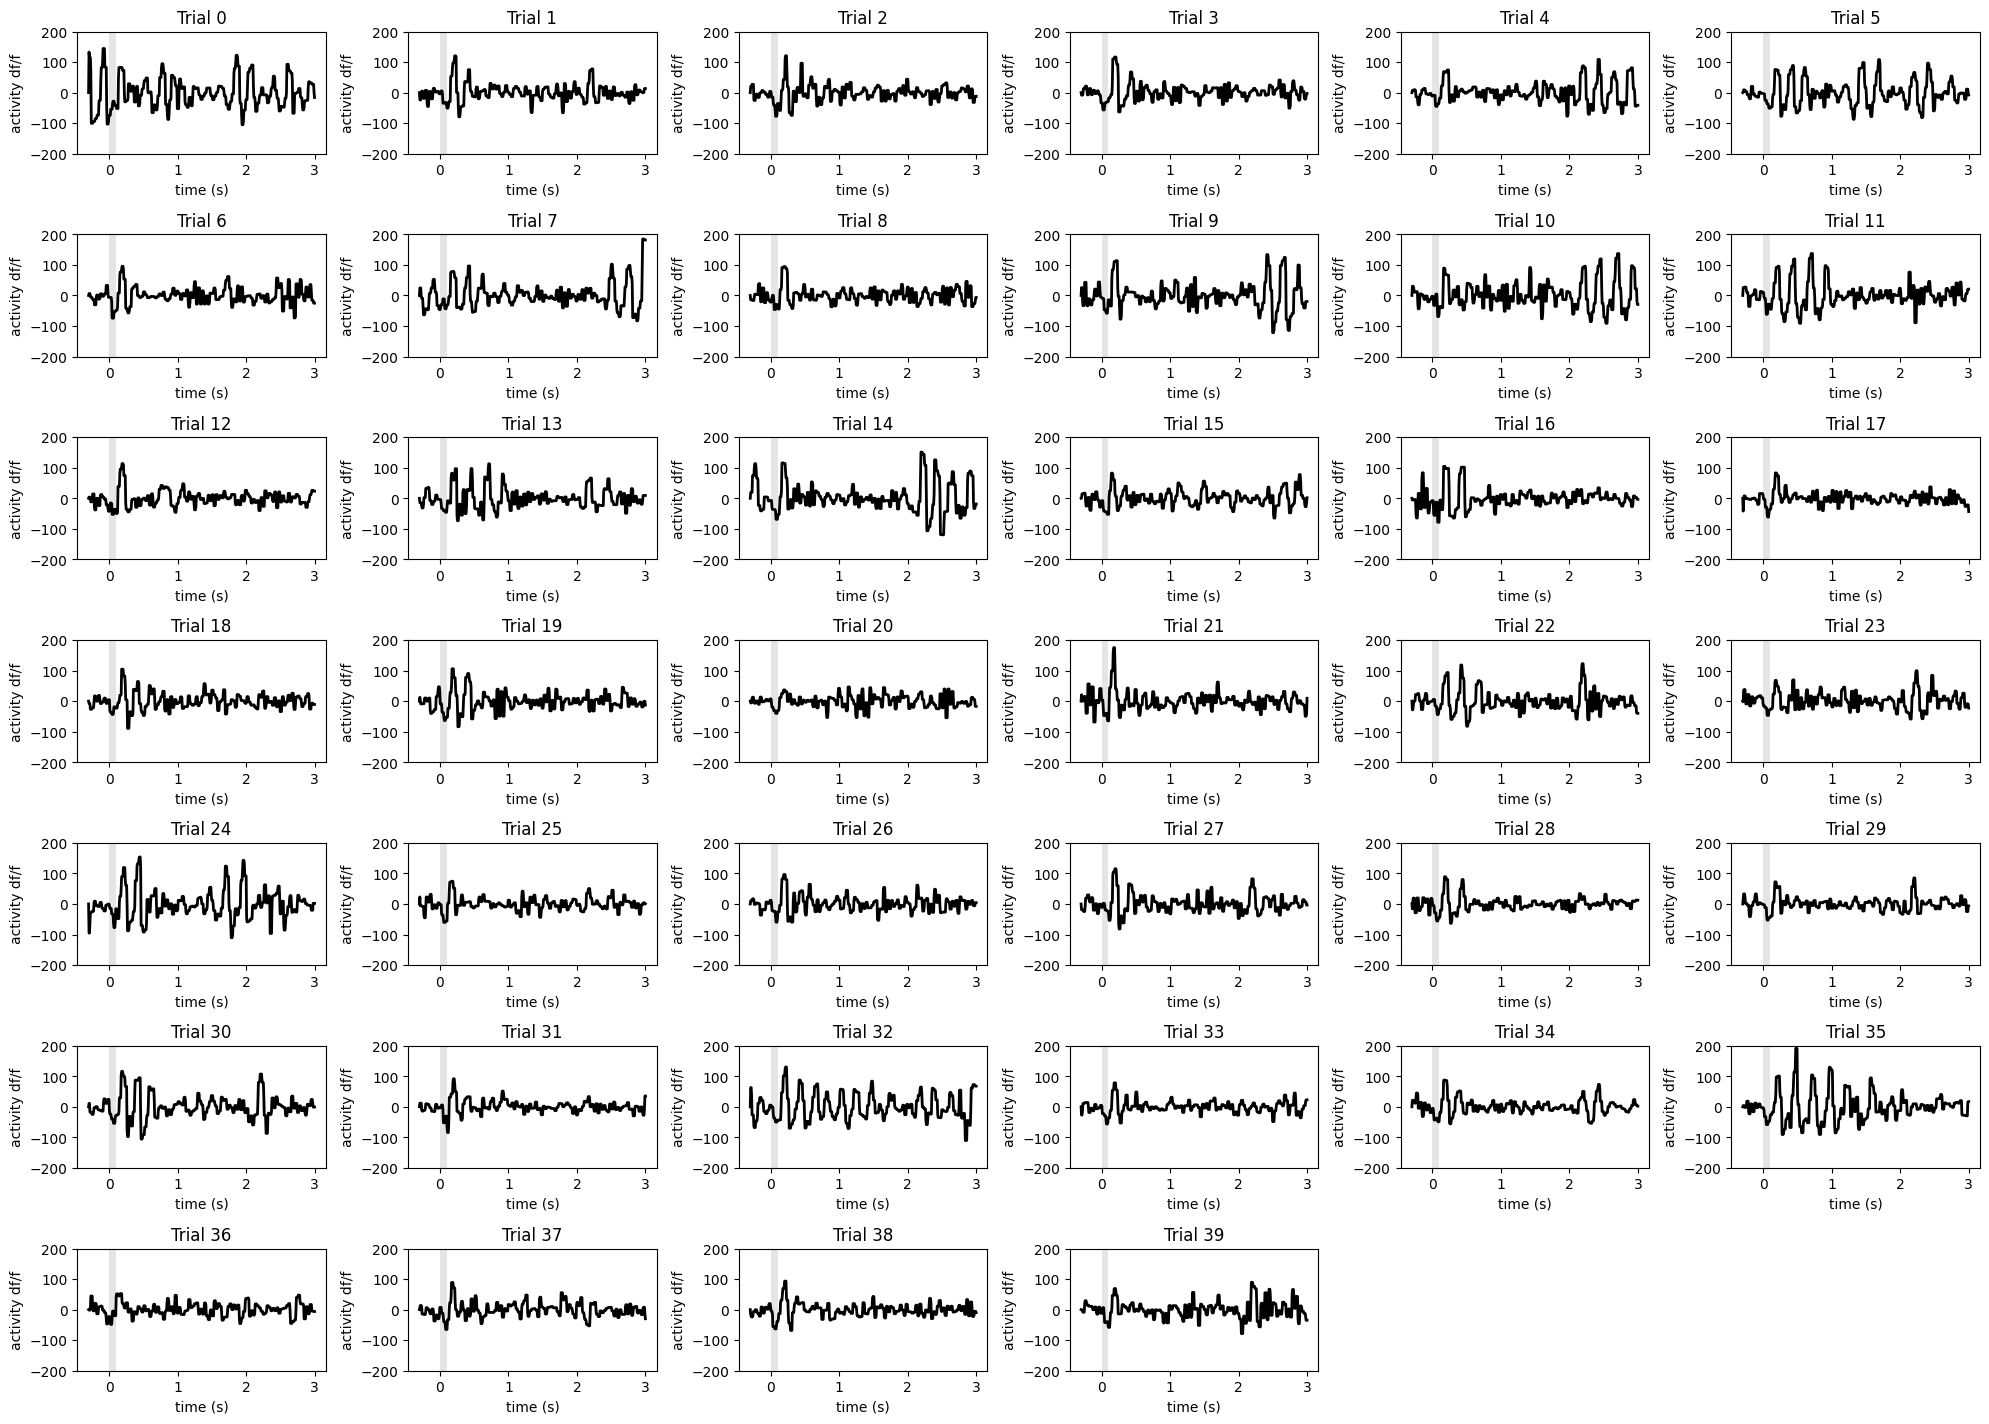

In [100]:
f = plt.figure(figsize=(20,20))
gs = mpl.gridspec.GridSpec(10,6) 

#presets and needs
power=1.5
pixel_ix = np.ravel_multi_index((450, 198), (dataOp425.py, dataOp425.px))
n_samples = 500
start=-.3
stop=3
timestamps = np.linspace(start, stop, n_samples)

#finding trs
pwTrs=np.argwhere(dataOp425.laserPowers==power).ravel()
galvoX=np.argwhere(dataOp425.galvoX==0).ravel()
galvoY=np.argwhere(dataOp425.galvoY==3.3).ravel()
loc=np.intersect1d(galvoX,galvoY).ravel()

theseTrs=np.intersect1d(loc,pwTrs)
onTimes = dataOp425.laserOn[theseTrs]
trs = [np.linspace(start+on, stop+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

#find times and get
for iT, tr in enumerate(trs):
    wf = dataOp425.tToWf(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataOp425.spatial[pixel_ix] @ dwf
    mov=np.array(mov)

    #set up axis
    ax=plt.subplot(gs[iT])
    ax.plot(timestamps, mov, linewidth=2,color='k')
    ax.axvspan(0,.1,color='gray',alpha=.2,lw=0,label='_nolegend_')
    ax.set_title(f'Trial {iT}')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('activity df/f')
    ax.set_ylim([-200,200])

    f.tight_layout()

## Contralat. Responses

<>:65: SyntaxWarning: invalid escape sequence '\D'
<>:65: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_21396\2328519300.py:65: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')


(-30.0, 30.0)

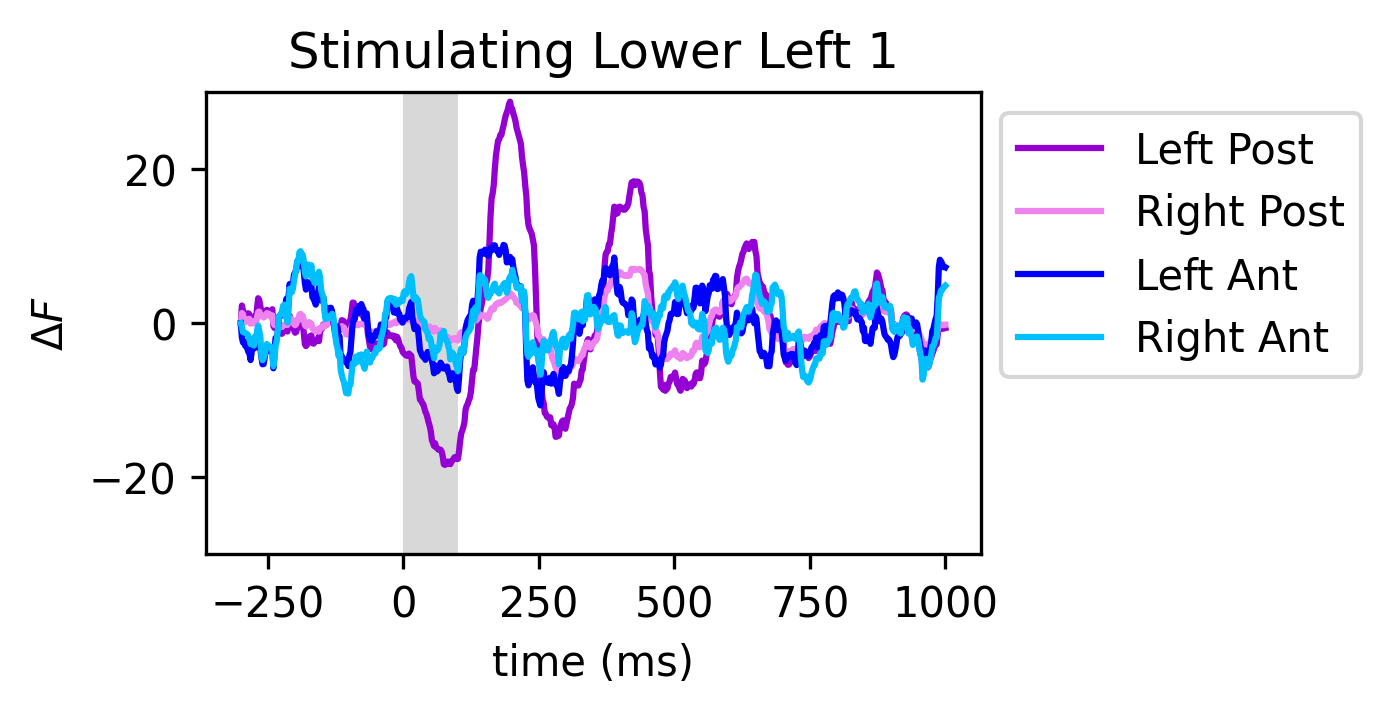

In [6]:
#presents
f = plt.figure(figsize=(5/1.5, 3/1.5), dpi=300)
ax = plt.gca()
power_pick = 1
n_samples=650
timestamps=np.linspace(-.3,1,n_samples)*1000
power = np.argwhere(dataOp425.laserPowers==power_pick).ravel() 
galvoX=np.argwhere(dataOp425.galvoX==0).ravel() #change for loc stim
galvoY=np.argwhere(dataOp425.galvoY==3.3).ravel() #change for loc stim


#all the pixels we might need
pixel_Right=np.ravel_multi_index((430,500),(dataOp425.py, dataOp425.px))
pixel_Left = np.ravel_multi_index((430,160),(dataOp425.py,dataOp425.px))
pixel_LeftFront=np.ravel_multi_index((150,200),(dataOp425.py, dataOp425.px))
pixel_RightFront=np.ravel_multi_index((150,400),(dataOp425.py, dataOp425.px))

#find trials
px = np.intersect1d(power,galvoX)
theseTrs=np.intersect1d(px,power)
onTimes=dataOp425.laserOn[theseTrs]
trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
trs=np.squeeze(np.array(trs))

thisPowerLeft=[]
thisPowerRight=[]
thisPowerLFront=[]
thisPowerRFront=[]
#finding movies for those trials in those locations
for iT, tr in enumerate(trs):
    wf=dataOp425.tToWf(tr)
    dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
    dwf=np.array(dwf)

    #find traces for each pixel
    movRight=dataOp425.svdSpat[pixel_Right]@dwf
    thisPowerRight.append(movRight)
    movLeft=dataOp425.svdSpat[pixel_Left]@dwf
    thisPowerLeft.append(movLeft)

    movRightFront=dataOp425.svdSpat[pixel_RightFront]@dwf
    thisPowerRFront.append(movRightFront)
    movLeftFront=dataOp425.svdSpat[pixel_LeftFront]@dwf
    thisPowerLFront.append(movLeftFront)

thisPowerLeft=np.array(thisPowerLeft)
thisPowerRight=np.array(thisPowerRight)
thisPowerLFront=np.array(thisPowerLFront)
thisPowerRFront=np.array(thisPowerRFront)

#plotting those trials and locations
plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='darkviolet',label='Left Post')
plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='violet',label='Right Post')
plt.plot(timestamps,np.mean(thisPowerLFront,axis=0),color='blue',label='Left Ant')
plt.plot(timestamps,np.mean(thisPowerRFront,axis=0),color='deepskyblue',label='Right Ant')
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.title(f'Stimulating Lower Left {power_pick}')
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$')
plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
plt.ylim([-30,30])

In [5]:
#make video - try with diff lengths of trials

power_pick = 1
n_samples=650
timestamps=np.linspace(-.3,1,n_samples)*1000
power = np.argwhere(dataOp425.laserPowers==power_pick).ravel() 
galvoX=np.argwhere(dataOp425.galvoX==0).ravel() #change for loc stim
galvoY=np.argwhere(dataOp425.galvoY==3.3).ravel() #change for loc stim

#find trials
px = np.intersect1d(galvoY,galvoX)
theseTrs=np.intersect1d(px,power)
allVideos=[]

#make videos for trials
for iT, tr in enumerate(theseTrs):
    startTime = dataOp425.laserOn[tr] - .3
    endTime = dataOp425.laserOn[tr] + 1

    trial_time = np.linspace(startTime, endTime, 100)
    trial_activity = dataOp425.tToWf(trial_time)
    
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
    dwf = np.array(dwf)

    #make avg brain
    video=dataOp425.spatial@dwf
    video = video.reshape(560,560,-1)
    allVideos.append(video)
allVideos=np.array(allVideos)
allVideosMean=np.mean(allVideos)


(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)
(560, 560, 100)


In [9]:
allVideos=np.array(allVideos)
allVideos.shape

(40, 560, 560, 100)

In [12]:
allVideosMean=np.mean(allVideos,axis=0)

In [13]:
allVideosMean.shape

(560, 560, 100)

In [18]:
allVideosOneFrame=np.mean(allVideosMean,axis=2)

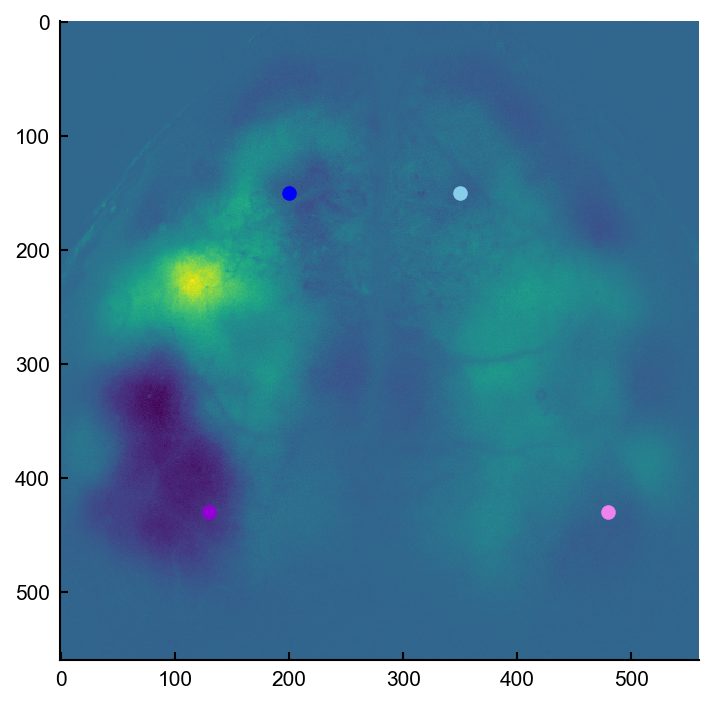

In [21]:
#show where the pixels im chosing are 

plt.imshow(allVideosOneFrame)
#add all those pixels im tracking
plt.scatter(480,430,color='violet')
plt.scatter(130,430,color='darkviolet')
plt.scatter(200,150,color='blue')
plt.scatter(350,150,color='skyblue')

### make a gif

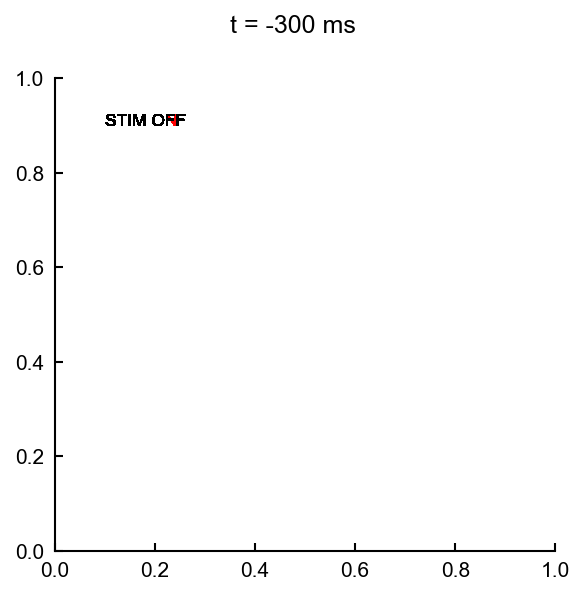

In [36]:
#find when the stim is on
f=plt.figure(figsize=(4, 4))
stimOn = np.intersect1d(np.argwhere(timestamps > 0).ravel(), np.argwhere(timestamps < 100).ravel())

#set up the frames to loop through for the animation
def animate(i):
    f.suptitle(f't = {timestamps[i]:.0f} ms')
    stext = plt.text(0.1, 0.9, '', fontsize='small')
    if np.isin(i, stimOn):
        stext.set_text('STIM ON')
        stext.set_color('red')
    else:
        stext.set_text('STIM OFF')
        stext.set_color('k')

anim = mpl.animation.FuncAnimation(f, animate, frames=n_samples-1, cache_frame_data=False, interval=250)
savepath = 'C:/Users/nadia/Documents/GitHub/steinmetzlab/wf + opto/power.gif'
# ptAL.plotting.anim_to_file(anim, str(savepath), rewrite=True, fps=25, bitrate=-1)
# ptAL.image.avi_to_gif(str(savepath), fps=4)
writergif=mpl.animation.PillowWriter(fps=30)
anim.save(savepath,writer=writergif)

## Visresp figs

In [64]:
dataFlicker=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-04-28\1'))

In [93]:
serverPath = Path(r'Y:\Subjects\AL_0032\2024-04-27\1')
timeFile = serverPath / 'cameraFrameTimes.npy'
frameTimes = np.squeeze(np.load(timeFile))[::2] # every other frame - we want blue only
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull = svdSpat[:,:,:500]

meanImage = np.load(serverPath / 'blue/meanImage.npy')
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
laserPowers = np.squeeze(np.load(serverPath /'laserPowers.npy'))
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
px, py, ncomps = svdSpatFull.shape

svdSpat = svdSpatFull.reshape(px*py, ncomps)

In [103]:
tToWf = scipy.interpolate.interp1d(frameTimes[:70943], svdTemp, axis=0, fill_value='extrapolate')
spatial = svdSpatFull.reshape(560*560,-1)

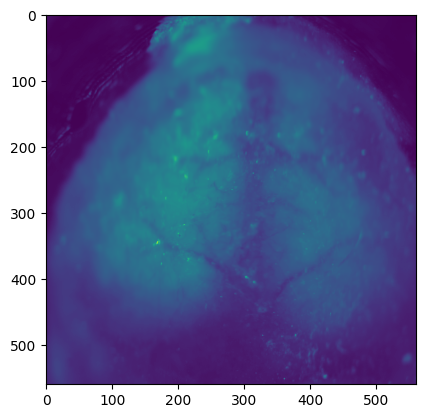

In [107]:
plt.imshow(meanImage)

In [106]:
print(np.unique(laserPowers))
print(np.unique(galvoX))
print(np.unique(galvoY))

[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[-0.]
[-0.   1.5  2.5]


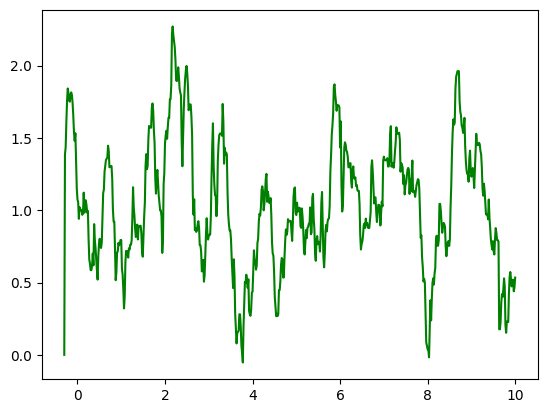

In [117]:
power = 3
pixel = (200, 350)
n_samples = 650
timestamps = np.linspace(-0.3, 10, n_samples)
locs=np.argwhere(galvoY==0).ravel()

pixel_ix = np.ravel_multi_index((350, 200), (py, px))
pows = np.argwhere(laserPowers == power).ravel()
times=np.intersect1d(pows,locs)
onTimes = laserOn[times]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

noFlicker = []
for iT, tr in enumerate(trs):
    wf = tToWf(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = svdSpat[pixel_ix] @ dwf
    noFlicker.append(mov)
noFlicker = np.array(noFlicker)

plt.plot(timestamps, np.mean(noFlicker, axis=0), color='green',label='no flicker')

Text(0.5, 1.0, '3 mW opto stim')

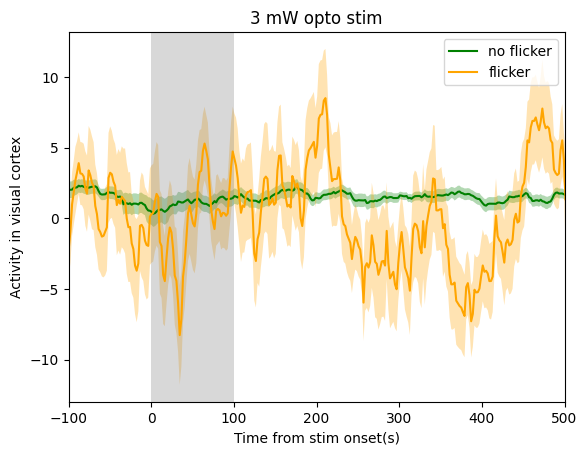

In [119]:
# process flicker
power = 3
pixel = (200, 400)
n_samples = 650
timestamps = np.linspace(-0.3, 10, n_samples)

pixel_ix = np.ravel_multi_index((400, 200), (dataFlicker.py, dataFlicker.px))
pows = np.argwhere(dataFlicker.laserPowers[dataFlicker.listExps[0]] == power).ravel()
locs=np.argwhere(dataFlicker.galvoY==0).ravel()
times=np.intersect1d(locs,pows)
onTimes = dataFlicker.laserOn[times]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = dataFlicker.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataFlicker.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

# process no flicker
power = 3
pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((400, 200), (py, px))
pows = np.argwhere(laserPowers == power).ravel()
locs=np.argwhere(dataFlicker.galvoY==-0).ravel()
times=np.intersect1d(locs,pows)
onTimes = dataFlicker.laserOn[times]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

noFlicker = []
for iT, tr in enumerate(trs):
    wf = tToWf(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = svdSpat[pixel_ix] @ dwf
    noFlicker.append(mov)
noFlicker = np.array(noFlicker)

plt.plot(timestamps, np.mean(noFlicker, axis=0), color='green',label='no flicker')
plt.fill_between(timestamps, \
                    np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                    np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color='green', alpha=0.3, lw=0, label='_nolegend_')

plt.plot(timestamps, np.mean(flicker,axis=0),color='orange',label='flicker')
plt.fill_between(timestamps, \
                    np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                    np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='orange', lw=0, label='_nolegend_', alpha=0.3)
plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
plt.legend()
plt.xlim([-100,500])
plt.xlabel('Time from stim onset(s)')
plt.ylabel('Activity in visual cortex')
plt.title(f'{power} mW opto stim')

In [87]:
noFlicker.shape

(0,)

In [ ]:
pow=3
visPow(ax,ylim,pow,dataFlicker,dataNo)

# visQuant

In [ ]:
mouse='AL_0027'
date="4/18"

In [ ]:
fig.savefig(f'C:\GitHub\steinmetzlab\wf + opto\figs\control\{mouse}_{date}')

## AL_0023

In [37]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-30\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


In [38]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-30\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


In [6]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-09\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[1. 4.]
[-0.]
[0.1 0.5 0.6 0.7]
[0.1]


In [8]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-11\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[1. 4.]
[-0.]
[0.1 0.5 1.  1.5 2.  2.5 3. ]
[0.1]


In [13]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-14\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[1. 4.]
[-0.]
[0.1 0.5 1.  1.5 2.  2.5 3. ]
[0.1]


In [14]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-15\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[1. 4.]
[-0.]
[1. 2. 3. 4. 5.]
[0.1]


In [15]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-23\3')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.   1.5  2.5]
[0.05 0.1  0.15 0.2  0.3  0.5  0.75 1.   1.5 ]
[0.1]


In [17]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-24\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.   1.5  2.5]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


In [20]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-25\2')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.   1.5  2.5]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


In [21]:
serverPath = Path(r'Z:\Subjects\AL_0023\2023-08-30\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]


## ZYE_0069

In [22]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-07-14\4')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[0.]
[0.]
[3.2]
[0.5]


In [40]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-07-14\6')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

FileNotFoundError: [Errno 2] No such file or directory: 'Z:\\Subjects\\ZYE_0069\\2023-07-14\\6\\galvoXPositions.npy'

In [29]:
# this one is messy since it switches halfway through
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-07-17\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.   3.3]
[0.]
[0.1 0.4 0.5 0.7 1.1 2.2 3.2]
[0.01 0.05 0.1  0.2  0.5 ]


In [31]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-07-19\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[0.  3.3]
[0.  3.3]
[0.5 1.  1.5 2.  3.2]
[0.1]


In [32]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-08-16\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.01 -0.  ]
[-0.01 -0.  ]
[0.1 0.2 0.5 0.7 1.  1.2 1.5 1.7 2. ]
[0.1]


In [35]:
serverPath = Path(r'Z:\Subjects\ZYE_0069\2023-08-22\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.05 0.1  0.15 0.2  0.3  0.5  0.75 1.   1.5 ]
[0.1]


## AL_0027

In [36]:
serverPath = Path(r'Z:\Subjects\AL_0027\2023-10-24\1')
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(serverPath/'laserPowers.npy'))
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
pulseLengths = []
for count,time in enumerate(laserOff):
        length = laserOff[count]-laserOn[count]
        length = round(length,2)
        pulseLengths.append(length)
pulseLengths = np.array(pulseLengths)
print(np.unique(galvoX))
print(np.unique(galvoY))
print(np.unique(laserPowers))
print(np.unique(pulseLengths))

[-0.]
[-0.]
[0.1  0.25 0.5  0.75 1.   1.5  2.   2.5  3.  ]
[0.1]
